# __Employee Turnover Analytics__

# __Import Libraries__

In [2]:
%pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\serge\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from imblearn.over_sampling import SMOTE



# __Import the Dataset & Quality Check__

In [ ]:
# importing the dataset
df = pd.read_csv('HR_comma_sep.csv')
print(df.head())

   satisfaction_level  last_evaluation  ...  sales  salary
0                0.38             0.53  ...  sales     low
1                0.80             0.86  ...  sales  medium
2                0.11             0.88  ...  sales  medium
3                0.72             0.87  ...  sales     low
4                0.37             0.52  ...  sales     low

[5 rows x 10 columns]


In [10]:
df.shape

(14999, 10)

Our dataframe has 10 columns with 14,999 entries.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [12]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


There are some columns we need to rename:

1. `average_montly_hours` to `average_monthly_hours`

2. `sales` to `department`

In [16]:
# rename 'average_montly_hours' to 'average_monthly_hours'
df.rename(columns={'average_montly_hours': 'average_monthly_hours'}, inplace=True)
df.rename(columns={'sales': 'department'}, inplace=True)

In [17]:
# checking for missing values
print(df.isnull().sum())

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64


Confirmed no missing or null values in our data.

We have a column with a capitalized letter that we need to rename.

1. `Work_accident` to `work_accident`

In [18]:
# rename 'Work_accident' to 'work_accident'
df.rename(columns={'Work_accident': 'work_accident'}, inplace=True)

In [24]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# __EDA__

- Correlation heatmap
- Distributions for satisfaction, evaluation, and hours
- Project count bar chart by turnover status

## __Correlation Heatmap__

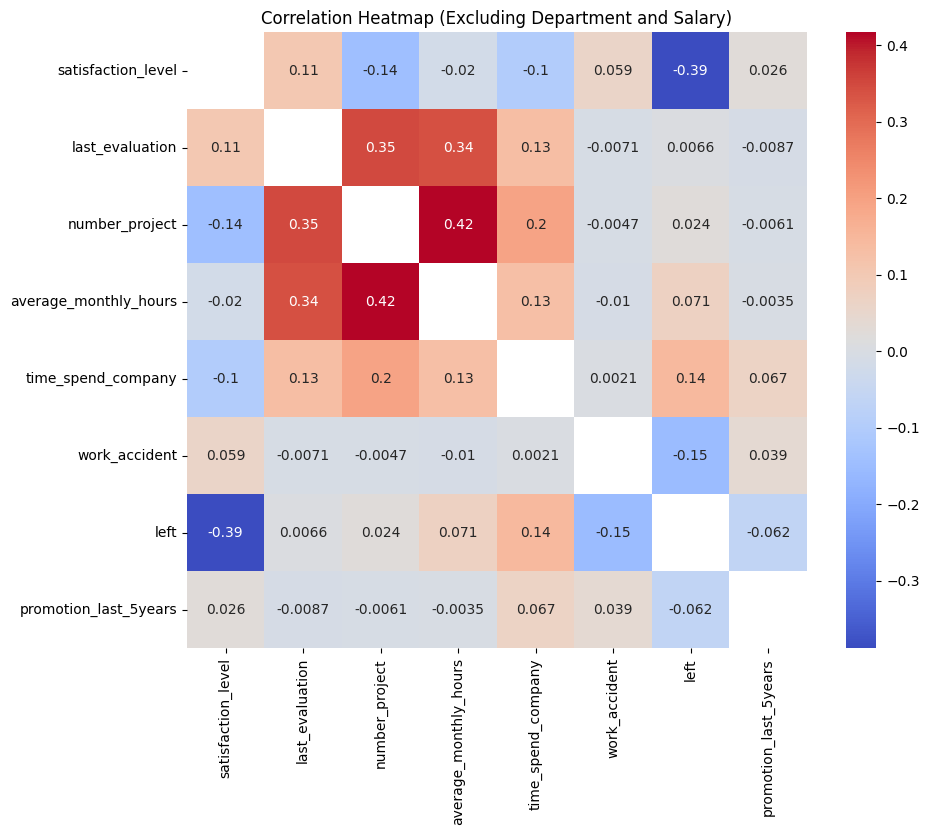

In [ ]:
columns_to_exclude = ['department', 'salary']
df_numeric = df[[col for col in df.columns if col not in columns_to_exclude]]
corr_matrix = df_numeric.corr()

mask = np.triu(np.ones_like(df_numeric.corr(), dtype=bool))
mask_diagonal = np.identity(len(corr_matrix), dtype=bool)

plt.figure(figsize=(10,8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', mask=mask_diagonal)
plt.title('Correlation Heatmap (Excluding Department and Salary)')
plt.show()

__Observation__

Based on the absolute values of the correlation coefficients:

__Strongest Positive Correlation__:

`average_monthly_hours` and `number_project`: `0.42`

- This indicates a moderately strong positive relationship. Employees who work on more projects tend to work more hours per month, which is an intuitive finding.

__Strongest Negative Correlation__:

`satisfaction_level` and `left`: `-0.39`

- This is the strongest (in magnitude) negative correlation observed. It suggests a significant inverse relationship: as an employee's satisfaction level decreases, their likelihood of leaving the company increases. This is a critical insight for understanding employee turnover.

## __Distributions: Satisfaction Level, Last Evaluation, Average Monthly Hours__

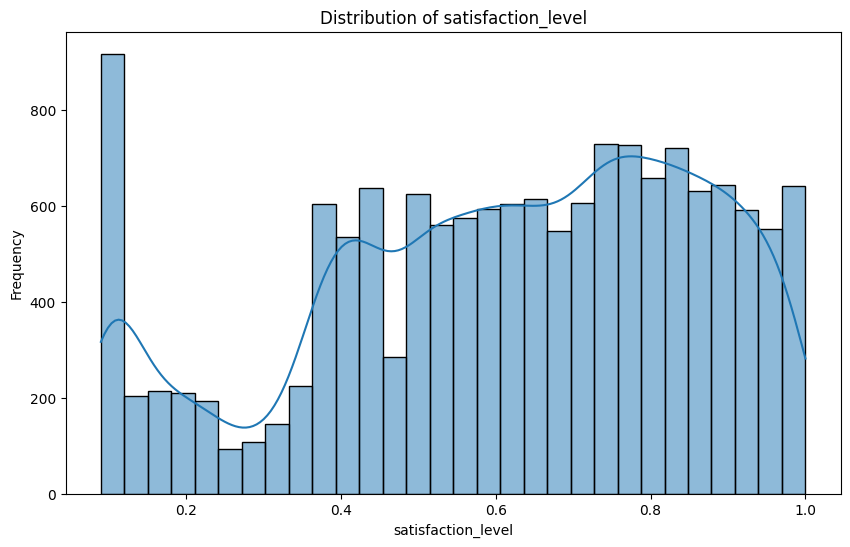

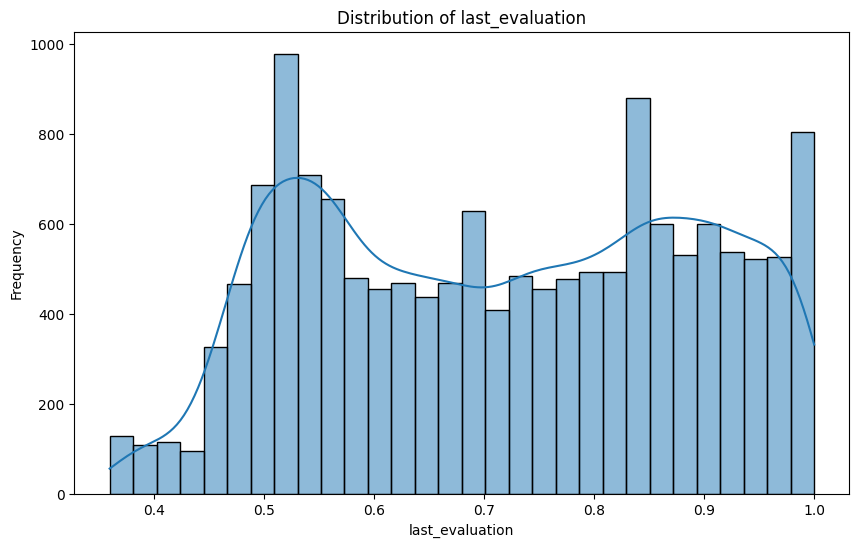

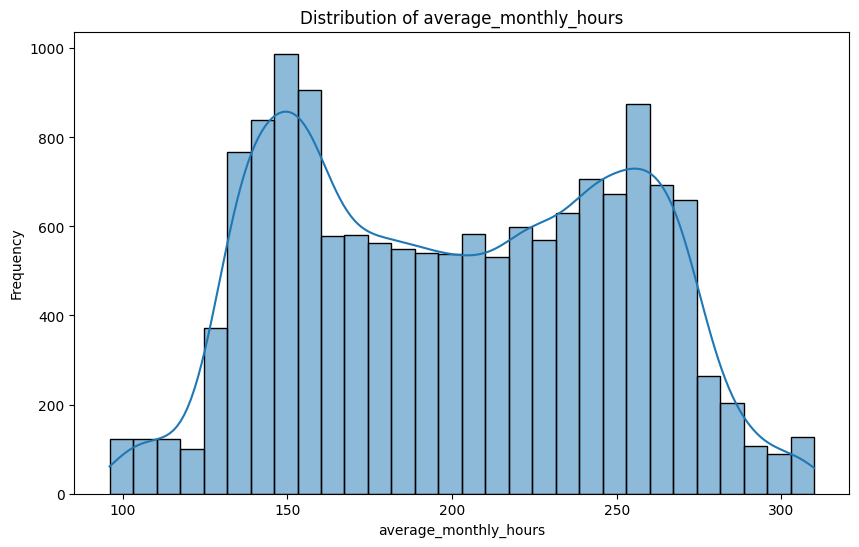

In [26]:
for col in ['satisfaction_level', 'last_evaluation', 'average_monthly_hours']:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins = 30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

### __Observations__

1. __satisfaction_level__

- Bi-modal distribution.

- There are two very distinct and prominent peaks in the distribution, suggesting that employee satisfaction levels are not uniformly distributed but rather cluster around specific values.

- __Low Satisfaction__: The 1st major peak shows a very high frequency of employees with a satisfaction_level around `0.1` to `0.15`. This is a significant finding, indicating a large group of highly dissatisfied employees.

- __High Satisfaction__: The 2nd major peak shows another significant cluster of with a satisfaction_level around `0.7` to `0.9`. This represents a group of highly satisfied employees.

- __Mid-Range Satisfaction__: There's a noticeable valley in the distribution for satisfaction_level values roughly between `0.25` and `0.35`. This implies that very few employees fall into this "moderately low" satisfaction range.

__Summary__

The distribution of `satisfaction_level` is not normal; it's highly skewed with two main concentrations. 

This suggests that employees are either very dissatisfied or quite satisfied, with fewer employees falling into a moderate or slightly below-average satisfaction range. 

This kind of distribution is often a strong signal for underlying segmentation or critical factors influencing employee sentiment.


2. __last_evaluation__

- Tri-modal distribution.

- __First Peak (Mid-Range Evaluation)__: There's a very prominent peak around last_evaluation scores of `0.5` to `0.55`. This suggests a large group of employees receiving a mid-range evaluation.

- __Second Peak (High Evaluation)__: Another significant peak is observed around `0.8` to `0.85`. This represents a substantial group of employees receiving high evaluation scores.

- __Third Peak (Very High/Near Perfect Evaluation)__: A notable peak also exists at or very close to last_evaluation of `1.0`. This indicates a significant number of employees receiving perfect or near-perfect evaluation scores.

__Summary__

The distribution of `last_evaluation` shows three prominent clusters of employees based on their performance evaluation scores, primarily at mid-range, high, and very high levels. 

This segmented distribution warrants further investigation to understand its relationship with other employee attributes and outcomes.

3. __average_monthly_hours__

- Bi-modal distribution with a gap in the middle.

- Similar to the `satisfaction_level`, this distribution is distinctly bi-modal, showing two prominent clusters of average monthly hours.

- __Lower Hours__: The 1st major peak shows there's a significant concentration of employees working around `150` to `160` average monthly hours. This represents a large segment of employees working a relatively standard or lower amount of hours.

- __Higher Hours__: The 2nd major peak is observed around `250` to `270` average monthly hours. This indicates a large group of employees working significantly higher hours, possibly close to or exceeding full-time equivalents if typical monthly hours are around `160` to `170`.

- __Mid-Range Hours__: There's a clear dip in the distribution for average_monthly_hours roughly between `180` and `220`. This implies that fewer employees work an "average" amount of hours, falling between the two extremes.

__Summary__

The distribution of `average_monthly_hours` is strongly bi-modal, indicating two distinct groups of employees: those working a standard/lower amount of hours and those working significantly higher hours. 

This pattern is vital for understanding employee workload dynamics and potential drivers of employee behavior, especially turnover.

## __Project by turnover status__

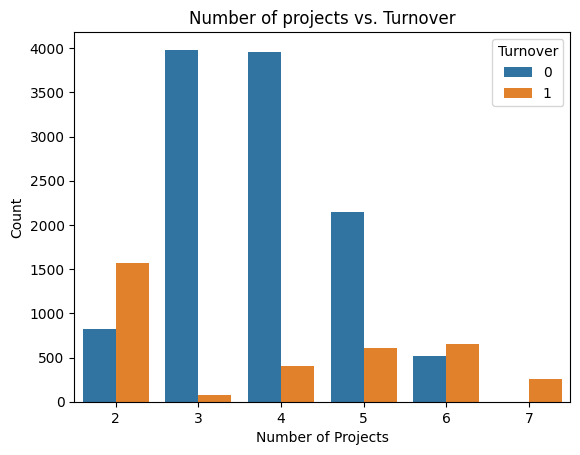

In [27]:
sns.countplot(data=df, x='number_project', hue='left')
plt.title('Number of projects vs. Turnover')
plt.xlabel('Number of Projects')
plt.ylabel('Count')
plt.legend(title='Turnover', loc='upper right')
plt.show()

### __Observation__

__Turnover = 0 (Stayed)__:

- Most employees who stayed had `3` or `4` projects (almost 4,000 employees each).

- Turnover is significantly lower for those with `3` and `4` projects.

- Fewer employees stayed with `6 or more` projects.

__Turnover = 1 (Left)__:

- Highest turnover occurred for employees with only `2` projects (~1,600).

- Noticeable turnover also among those with `5`, `6`, or `7` projects, suggesting a possible burnout or dissatisfaction at higher workloads.

- Very low turnover at `3` projects.

__Summary__

Low or high project load may correlate with higher employee turnover, while a moderate load `(3 to 4 projects)` seems to be linked with higher retention.

# __KMeans Clustering__

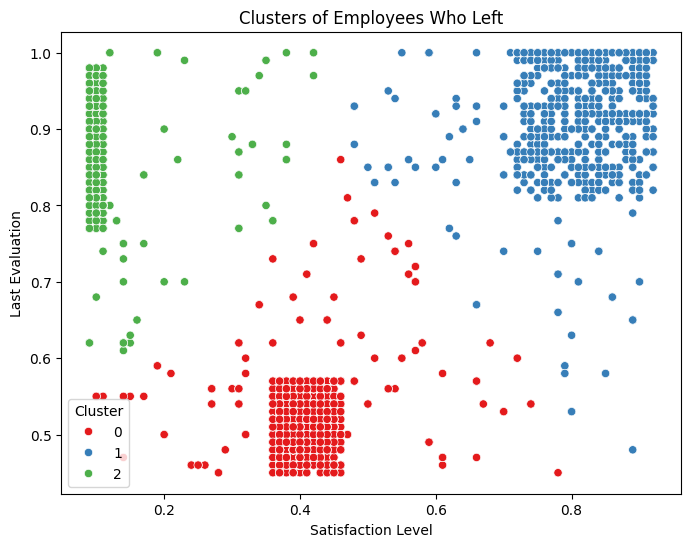

In [29]:
left_df = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']]
kmeans = KMeans(n_clusters=3, random_state=42)
left_df['cluster'] = kmeans.fit_predict(left_df)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=left_df, x='satisfaction_level', y='last_evaluation', hue='cluster', palette='Set1')
plt.title('Clusters of Employees Who Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.legend(title='Cluster')
plt.show()


### __Observations__

__Cluster 0 (Red - The "Underperformers" or "Disengaged")__:

**Profile**:

These employees left despite having mid-range evaluations, suggesting they were not necessarily poor performers based on their last evaluation. However, their satisfaction was low.

__Potential Reason for Leaving__:

- This group might represent employees who were disengaged, felt their mid-range performance wasn't good enough, or were simply unhappy even if their performance wasn't at the very bottom.

- They might have left due to general dissatisfaction, a lack of recognition, or finding better opportunities.


__Cluster 1 (Blue - The "Overworked High-Performers" or "Burnout Victims")__:

**Profile**: 

These employees are characterized by very high satisfaction levels and very high last evaluation scores.

__Potential Reason for Leaving__: 

- This cluster strongly suggests burnout or excessive workload. 

- High satisfaction could be a temporary state or a result of their commitment, but combined with very high evaluation (implying demanding roles or high output), it might indicate unsustainable pressure leading to departure. 

- They might be leaving for better work-life balance or less stressful environments.


__Cluster 2 (Green - The "Truly Unhappy/Under-valued" or "Low Performers")__:

__Profile__: 

This cluster represents employees with extremely low satisfaction levels (often below 0.2) but a wide range of evaluation scores, including many who had high evaluations.

__Potential Reason for Leaving__: 

- This group seems to be leaving primarily due to extreme dissatisfaction, regardless of their performance. 

- Those with high evaluations in this group might be feeling undervalued despite their efforts, while those with lower evaluations are simply unhappy. 

- This could point to issues with management, company culture, or overall morale for a specific segment.

# __Class Imbalance__

## __Pre-Processing__

In [30]:
df_encoded = pd.get_dummies(df, columns=['department', 'salary'], drop_first=True)
X =df_encoded.drop('left', axis=1)
y =df_encoded['left']

## __Test-train Split__

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

## __Synthetic Minority Over-sampling Technique (SMOTE)__

In [38]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())

Class distribution after SMOTE:
 left
0    9142
1    9142
Name: count, dtype: int64


In [39]:
from collections import Counter
print(f"Original dataset shape: {Counter(y_train)}")
print(f"Resampled dataset shape: {Counter(y_resampled)}")

Original dataset shape: Counter({0: 9142, 1: 2857})
Resampled dataset shape: Counter({0: 9142, 1: 9142})


### __Observation__

**Before SMOTE**: 

The original training dataset was imbalanced, with significantly fewer instances of employees who left (`2857`).

**After SMOTE**: 

The SMOTE algorithm successfully synthesized new samples for the minority class, resulting in a perfectly balanced dataset.

Both classes (employees who stayed `0` and employees who left `1`) have an equal number of instances (`9142`), achieve a 1:1 ratio.

# __Model Training & Evaluation__

Train the `Logistic Regression`, `Random Forest Classifier`, and `Gradient Boosting Classifier` models 

Apply a 5-fold CV, and plot the classification report.

## __Evaluating the Models__

In [ ]:
def evaluate_model(model, X, y, model_name):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # StratifiedKFold for balanced class distribution
    y_pred = cross_val_predict(model, X, y, cv=skf)
    print(f"\nClassification Report - {model_name}:\n", classification_report(y, y_pred))

    y_proba = cross_val_predict(model, X, y, cv=skf, method='predict_proba')[:, 1] # Get probabilities for the positive class
    fpr, tpr, _ = roc_curve(y, y_proba) # Calculate ROC curve
    roc_auc = auc(fpr, tpr) # Calculate AUC
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    return y_pred, y_proba, roc_auc



## __Training the Models__

In [42]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

## __Comparing the Models__


Classification Report - Logistic Regression:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      9142
           1       0.78      0.82      0.80      9142

    accuracy                           0.79     18284
   macro avg       0.80      0.79      0.79     18284
weighted avg       0.80      0.79      0.79     18284


Classification Report - Random Forest:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      9142
           1       0.99      0.97      0.98      9142

    accuracy                           0.98     18284
   macro avg       0.98      0.98      0.98     18284
weighted avg       0.98      0.98      0.98     18284


Classification Report - Gradient Boosting:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      9142
           1       0.98      0.95      0.96      9142

    accuracy                           0.96     1

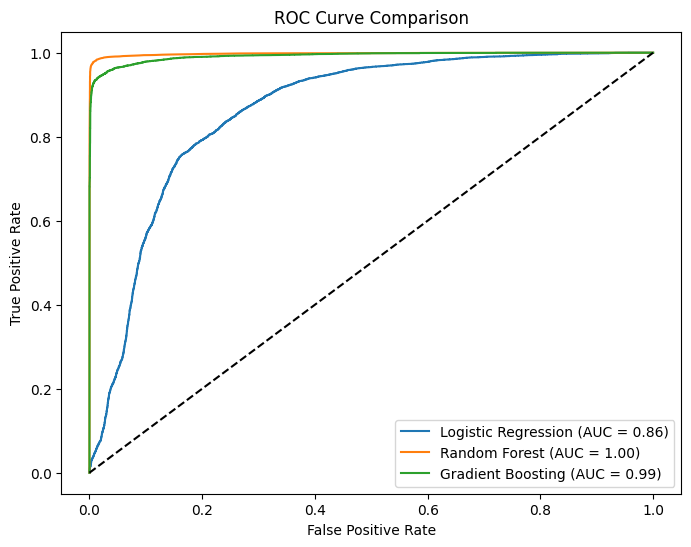

In [ ]:
plt.figure(figsize=(8, 6))
results = {}
for name, model in models.items():
    y_pred, y_proba, roc_auc = evaluate_model(model, X_resampled, y_resampled, name)
    results[name] = {'model': model, 'roc_auc': roc_auc}

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

### __Observation__

**Random Forest (`AUC = 1.00`)**: 

- Shows perfect discriminative power. Its curve shoots directly to the top-left corner (`TPR=1`, `FPR=0`). 

- This indicates it perfectly separates classes on the training/validation data it was evaluated on. 


**Gradient Boosting (`AUC = 0.99`)**: 

- Also shows excellent discriminative power, very close to perfect.

**Logistic Regression (`AUC = 0.86`)**: 

- Shows good discriminative power, but noticeably less than the ensemble models.

**Summary**

- Both Random Forest and Gradient Boosting models are highly effective at distinguishing between employees who leave and those who stay. 

- The significantly higher AUC of the ensemble models compared to Logistic Regression suggests their non-linear capabilities are better suited for this dataset's underlying patterns. 

- The near-perfect AUC of Random Forest should be cautiously interpreted; while it indicates strong performance, it's worth verifying its generalizability to truly unseen data.

# __Best Model Prediction__

## __Area Under the Curve__


✅ Best Model Selected: Random Forest


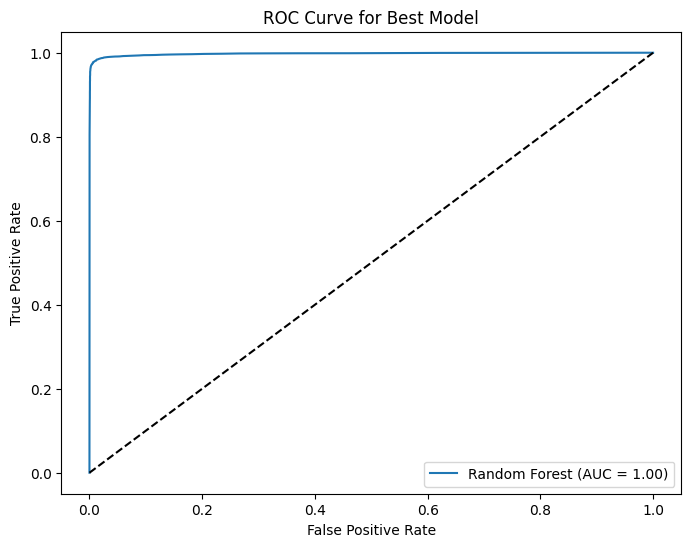

In [49]:
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']
print(f"\n✅ Best Model Selected: {best_model_name}")

# plot the ROC curve for the best model
y_proba_best = cross_val_predict(best_model, X_resampled, y_resampled, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), method='predict_proba')[:, 1]
fpr_best, tpr_best, _ = roc_curve(y_resampled, y_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, label=f"{best_model_name} (AUC = {roc_auc_best:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Best Model")
plt.legend()
plt.show()

### __Observation__

Based purely on the ROC Curve Comparison chart, `Random Forest` is considered the best model due to its perfect AUC score of `1.00`.

Its curve perfectly reaching the top-left corner, indicating superior discriminative power between employees who leave and those who stay, compared to Logistic Regression and Gradient Boosting.

### __Concerns__

While an AUC of `1.00` is technically the best possible score, it's so perfect that it often warrants a critical review of the data and modeling process.

We have to consider potential for `Overfitting` and `Data Leakage` in the data

## __Confusion Matrix__

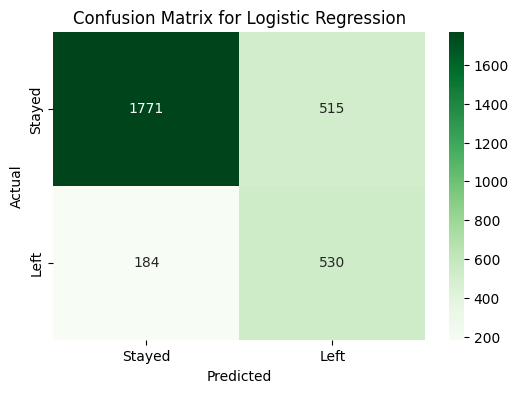

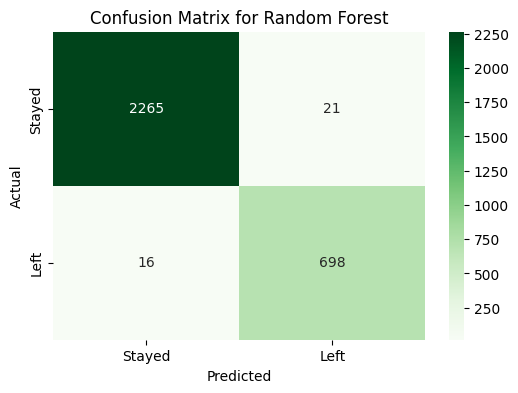

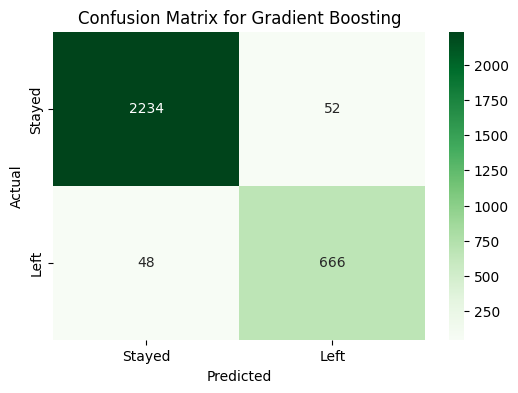

In [58]:
# Generate predictions for each model on the test set
predictions = {}
for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    predictions[model_name] = model.predict(X_test)

# Plot confusion matrices
for model_name in models:
    cm = confusion_matrix(y_test, predictions[model_name])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Confusion Matrix:
[[2265   21]
 [  16  698]]


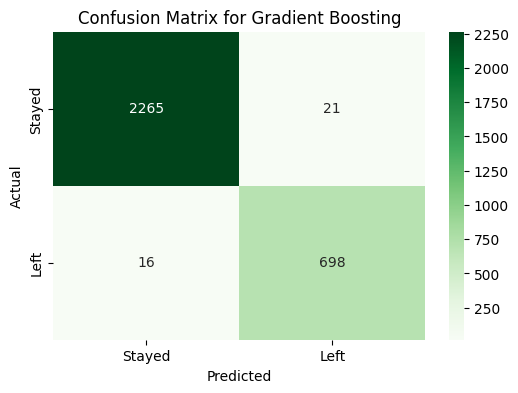

In [59]:
best_model.fit(X_resampled, y_resampled)
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(f"\nConfusion Matrix:\n{conf_matrix}")

# Plot confusion matrix for the best model
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### __Observation__

|                          | Predicted Negative (Stayed) | Predicted Positive (Left) |
| ------------------------ | --------------------------- | ------------------------- |
| Actual Negative (Stayed) | True Negative (TN)          | False Positive (FP)       |
| Actual Positive (Left)   | False Negative (FN)         | True Positive (TP)        |


|                          | Predicted Negative (Stayed) | Predicted Positive (Left) |
| ------------------------ | --------------------------- | ------------------------- |
| Actual Negative (Stayed) |            `2265`           | `21`                      |
| Actual Positive (Left)   |            `16`             | `698`                     |



**Summary**

**High Accuracy on Both Classes**: 

- It has a very high number of correct predictions (`TN = 2265`, `TP = 698`) and very low numbers of incorrect predictions (`FP = 21`, `FN = 16`).

**Effective at Identifying Leavers**: 

- The low number of False Negatives (`16`) and high number of True Positives (`698`) means the model is very good at catching employees who are about to churn. 

- This is critical for practical applications.

**Low False Alarms**: 

- The low number of False Positives (`21`) means the model isn't making too many incorrect "leave" predictions.

# __Risk Zones & Retention Strategies__

In [54]:
risk_zone = pd.DataFrame({'probability': y_test_proba})
print("\nRisk Zone (Probability of Leaving):\n", risk_zone.describe())


Risk Zone (Probability of Leaving):
        probability
count  3000.000000
mean      0.262910
std       0.403412
min       0.000000
25%       0.000000
50%       0.030000
75%       0.350000
max       1.000000


In [52]:
risk_zone['zone'] = pd.cut(risk_zone['probability'], bins=[0.0, 0.2, 0.6, 0.9, 1.0], labels=['Safe', 'Low Risk', 'Medium Risk', 'High Risk'])
print("\nRisk Zone Distribution:\n", risk_zone['zone'].value_counts())


Risk Zone Distribution:
 zone
Safe           1242
High Risk       646
Low Risk        111
Medium Risk      59
Name: count, dtype: int64


In [55]:
strategies = {
    'Safe': '✅ Maintain current engagement strategies.',
    'Low Risk': '🟡 Monitor satisfaction levels and provide additional support.',
    'Medium Risk': '🟠 Implement targeted retention strategies, such as career development opportunities.',
    'High Risk': '🔴 Immediate intervention required, such as one-on-one meetings to address concerns.'
}

for zone, strategy in strategies.items():
    print(f"{zone} Zone: {strategy}")

Safe Zone: ✅ Maintain current engagement strategies.
Low Risk Zone: 🟡 Monitor satisfaction levels and provide additional support.
Medium Risk Zone: 🟠 Implement targeted retention strategies, such as career development opportunities.
High Risk Zone: 🔴 Immediate intervention required, such as one-on-one meetings to address concerns.


### __Observations__

**Probability**:

- The "Risk Zone (Probability of Leaving)" statistics indicate that while the average predicted risk of an employee leaving is relatively low (`26.3%`), the distribution of these probabilities is heavily skewed towards very low risk. 

- A large portion of employees are predicted to have almost no chance of leaving (`25%` are at `0%` probability, and the median is only `3%`). 

- However, the high standard deviation and the fact that the maximum probability is 100% show that there are indeed employees identified by the model as being at a much higher risk of leaving, pulling the mean up.

**Risk Zone Distribution**:

- The distribution shows a large segment of employees are deemed very safe, but there's also a substantial group identified as high risk. 

- The relatively small numbers in the "Low Risk" and "Medium Risk" categories suggest that the model is effectively segmenting employees into clear "stay" or "leave soon" buckets, rather than a broad spectrum of moderate risk.

- The focus should clearly be on the 646 employees in the "High Risk" zone for immediate retention efforts, while maintaining engagement for the large "Safe" group.

**Strategies**:

- Safe Zone (Green Checkmark): Represents employees with a score of `< 20%`, hence, the lowest probability of leaving.

- Low Risk Zone (Yellow Circle): Indicates employees with a score of between `20% and < 60%`. A slightly higher, but still manageable probability of leaving.

- Medium Risk Zone (Orange Circle): Identifies employees with a socre between `60% and < 90%`. A Moderate probability of leaving, requiring more direct attention.

- High Risk Zone (Red Circle): Pinpoints employees with the highest probability of leaving, demanding urgent intervention. This zone has a score `> 90%`.
